In [1]:
# ==========================================
# 📚 NOTEBOOK 04 - MODEL INFERENCE
# 🎯 Objectif: Utiliser le modèle entraîné sur nouvelles images
# ==========================================

# CELLULE 1 - IMPORTS ET SETUP
# =============================

import torch
import torch.nn as nn
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
from datetime import datetime
import albumentations as A
from albumentations.pytorch import ToTensorV2
import warnings
warnings.filterwarnings('ignore')

print("🔧 NOTEBOOK 04 - INFÉRENCE DU MODÈLE ENTRAÎNÉ")
print("=" * 50)

# Configuration (identique à l'entraînement)
CONFIG = {
    'image_size': (512, 512),
    'num_classes': 2,
    'normalize_mean': [0.485, 0.456, 0.406],
    'normalize_std': [0.229, 0.224, 0.225]
}

# Chemins
MODEL_PATH = Path("../models/best_model.pth")
RESULTS_PATH = Path("../results")
RESULTS_PATH.mkdir(exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"⚡ Device: {device}")

🔧 NOTEBOOK 04 - INFÉRENCE DU MODÈLE ENTRAÎNÉ
⚡ Device: cpu


In [2]:
# ==========================================
# CELLULE 2 - CHARGEMENT DU MODÈLE ENTRAÎNÉ
# ==========================================

def create_model(num_classes):
    """Créer l'architecture du modèle (identique à l'entraînement)"""
    model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

print("🔄 Chargement du modèle entraîné...")

# Créer l'architecture
model = create_model(CONFIG['num_classes'])

# Charger les poids entraînés
if MODEL_PATH.exists():
    checkpoint = torch.load(MODEL_PATH, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    print(f"✅ Modèle chargé avec succès!")
    print(f"   🏆 Époque: {checkpoint['epoch'] + 1}")
    print(f"   📊 Train Loss: {checkpoint['train_loss']:.4f}")
    print(f"   🎯 Validation Loss: {checkpoint['val_loss']:.4f}")
    print(f"   📅 Configuration: {checkpoint.get('config', 'Non disponible')}")
else:
    print(f"❌ ERREUR: Modèle non trouvé à {MODEL_PATH}")
    print("   💡 Assure-toi d'avoir exécuté le notebook 03_model_training.ipynb")

model.to(device)
model.eval()
print(f"🧠 Modèle prêt pour l'inférence!")

🔄 Chargement du modèle entraîné...
✅ Modèle chargé avec succès!
   🏆 Époque: 10
   📊 Train Loss: 0.1428
   🎯 Validation Loss: 0.1188
   📅 Configuration: {'image_size': (512, 512), 'num_classes': 2, 'batch_size': 4, 'learning_rate': 0.001, 'num_epochs': 10, 'normalize_mean': [0.485, 0.456, 0.406], 'normalize_std': [0.229, 0.224, 0.225], 'weight_decay': 0.0001, 'step_size': 5, 'gamma': 0.1}
🧠 Modèle prêt pour l'inférence!


In [3]:
# ==========================================
# CELLULE 3 - PREPROCESSING DES IMAGES
# ==========================================

def get_inference_transforms():
    """Transformations pour l'inférence (sans augmentation)"""
    return A.Compose([
        A.Normalize(mean=CONFIG['normalize_mean'], std=CONFIG['normalize_std']),
        ToTensorV2()
    ])

def preprocess_image(image_path, target_size=CONFIG['image_size']):
    """
    Preprocesser une image pour l'inférence

    Args:
        image_path: Chemin vers l'image
        target_size: Taille cible (width, height)

    Returns:
        image_tensor: Tensor prêt pour le modèle
        original_image: Image originale (RGB)
        scale_factors: Facteurs d'échelle pour reconvertir les coordonnées
    """
    # Charger l'image
    image = cv2.imread(str(image_path))
    if image is None:
        raise ValueError(f"Impossible de charger l'image: {image_path}")

    # Convertir en RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_height, original_width = image_rgb.shape[:2]

    # Redimensionner
    target_width, target_height = target_size
    image_resized = cv2.resize(image_rgb, (target_width, target_height))

    # Calcul des facteurs d'échelle
    scale_x = original_width / target_width
    scale_y = original_height / target_height

    # Transformations
    transforms = get_inference_transforms()
    transformed = transforms(image=image_resized)
    image_tensor = transformed['image'].unsqueeze(0)  # Ajouter dimension batch

    return image_tensor, image_rgb, (scale_x, scale_y)

print("✅ Fonctions de preprocessing définies")


✅ Fonctions de preprocessing définies


In [4]:

# ==========================================
# CELLULE 4 - CLASSE D'INFÉRENCE PRINCIPALE
# ==========================================

class LungNoduleInference:
    """
    Classe principale pour l'inférence de détection de nodules
    """

    def __init__(self, model, config, device):
        self.model = model
        self.config = config
        self.device = device
        self.model.eval()

        # Statistiques
        self.inference_stats = {
            'total_images_processed': 0,
            'total_nodules_detected': 0,
            'processing_times': [],
            'inference_history': []
        }

    def detect_nodules(self, image_path, confidence_threshold=0.5, nms_threshold=0.3):
        """
        Détecter les nodules dans une image

        Args:
            image_path: Chemin vers l'image
            confidence_threshold: Seuil de confiance minimum
            nms_threshold: Seuil pour Non-Maximum Suppression

        Returns:
            dict: Résultats de détection
        """
        start_time = datetime.now()

        # Preprocessing
        image_tensor, original_image, scale_factors = preprocess_image(image_path)
        image_tensor = image_tensor.to(self.device)

        # Inférence
        with torch.no_grad():
            predictions = self.model(image_tensor)

        # Extraire les résultats
        pred = predictions[0]
        boxes = pred['boxes'].cpu().numpy()
        scores = pred['scores'].cpu().numpy()
        labels = pred['labels'].cpu().numpy()

        # Filtrer par confidence
        mask = scores >= confidence_threshold
        filtered_boxes = boxes[mask]
        filtered_scores = scores[mask]
        filtered_labels = labels[mask]

        # Convertir les coordonnées vers l'image originale
        scale_x, scale_y = scale_factors
        original_boxes = []

        for box in filtered_boxes:
            x1, y1, x2, y2 = box
            original_boxes.append([
                x1 * scale_x,
                y1 * scale_y,
                x2 * scale_x,
                y2 * scale_y
            ])

        # Calcul du temps de traitement
        processing_time = (datetime.now() - start_time).total_seconds()

        # Construire les résultats
        results = {
            'image_path': str(image_path),
            'image_name': Path(image_path).name,
            'timestamp': start_time.isoformat(),
            'processing_time_seconds': processing_time,
            'original_image_size': original_image.shape[:2],  # (height, width)
            'model_input_size': self.config['image_size'],
            'confidence_threshold': confidence_threshold,
            'total_detections': len(original_boxes),
            'detections': []
        }

        # Détails de chaque détection
        for i, (box, score, label) in enumerate(zip(original_boxes, filtered_scores, filtered_labels)):
            x1, y1, x2, y2 = box
            area = (x2 - x1) * (y2 - y1)

            results['detections'].append({
                'detection_id': i + 1,
                'bbox': [float(x1), float(y1), float(x2), float(y2)],
                'confidence': float(score),
                'class_name': 'nodule',
                'class_id': int(label),
                'area_pixels': float(area),
                'center': [float((x1 + x2) / 2), float((y1 + y2) / 2)]
            })

        # Mettre à jour les statistiques
        self._update_stats(results, processing_time)

        return results, original_image

    def _update_stats(self, results, processing_time):
        """Mettre à jour les statistiques d'inférence"""
        self.inference_stats['total_images_processed'] += 1
        self.inference_stats['total_nodules_detected'] += results['total_detections']
        self.inference_stats['processing_times'].append(processing_time)

        self.inference_stats['inference_history'].append({
            'image_name': results['image_name'],
            'nodules_count': results['total_detections'],
            'max_confidence': max([d['confidence'] for d in results['detections']], default=0.0),
            'processing_time': processing_time,
            'timestamp': results['timestamp']
        })

    def visualize_detections(self, original_image, results, save_path=None, show_confidence=True):
        """
        Visualiser les détections sur l'image
        """
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        ax.imshow(original_image)

        # Dessiner chaque détection
        for detection in results['detections']:
            box = detection['bbox']
            confidence = detection['confidence']
            det_id = detection['detection_id']

            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1

            # Couleur selon la confidence
            if confidence >= 0.8:
                color = 'lime'
                priority = 'HAUTE'
            elif confidence >= 0.6:
                color = 'yellow'
                priority = 'MOYENNE'
            elif confidence >= 0.4:
                color = 'orange'
                priority = 'FAIBLE'
            else:
                color = 'red'
                priority = 'TRÈS FAIBLE'

            # Rectangle
            rect = plt.Rectangle((x1, y1), width, height,
                               fill=False, color=color, linewidth=3)
            ax.add_patch(rect)

            # Texte
            if show_confidence:
                text = f'#{det_id}: {confidence:.1%}\n({priority})'
            else:
                text = f'Nodule #{det_id}'

            ax.text(x1, y1-10, text,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.8),
                   fontsize=10, color='black', fontweight='bold')

        # Titre
        title = f"🫁 Détection de Nodules - {results['image_name']}\n"
        title += f"📊 {results['total_detections']} nodule(s) | "
        title += f"🎯 Seuil: {results['confidence_threshold']:.1%} | "
        title += f"⏱️ {results['processing_time_seconds']:.2f}s"

        ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
        ax.axis('off')

        # Sauvegarder si demandé
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"💾 Résultat sauvegardé: {save_path}")

        plt.show()

    def save_results(self, results, save_dir=None):
        """
        Sauvegarder les résultats en JSON
        """
        if save_dir is None:
            save_dir = RESULTS_PATH

        save_dir = Path(save_dir)
        save_dir.mkdir(exist_ok=True)

        # Nom de fichier basé sur l'image et timestamp
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        image_name = Path(results['image_name']).stem
        filename = f"{image_name}_{timestamp}_results.json"

        save_path = save_dir / filename

        with open(save_path, 'w') as f:
            json.dump(results, f, indent=2, default=str)

        print(f"💾 Résultats sauvegardés: {save_path}")
        return save_path

    def get_stats(self):
        """Afficher les statistiques d'inférence"""
        stats = self.inference_stats

        print("📊 STATISTIQUES D'INFÉRENCE")
        print("=" * 30)
        print(f"🖼️  Images traitées: {stats['total_images_processed']}")
        print(f"🎯 Nodules détectés: {stats['total_nodules_detected']}")

        if stats['total_images_processed'] > 0:
            avg_nodules = stats['total_nodules_detected'] / stats['total_images_processed']
            print(f"📈 Moyenne: {avg_nodules:.1f} nodules/image")

        if stats['processing_times']:
            avg_time = np.mean(stats['processing_times'])
            print(f"⏱️ Temps moyen: {avg_time:.3f}s/image")
            print(f"🚀 Vitesse: {1/avg_time:.1f} images/seconde")

# Créer l'instance d'inférence
inference_engine = LungNoduleInference(model, CONFIG, device)
print("✅ Moteur d'inférence créé et prêt!")

✅ Moteur d'inférence créé et prêt!



🧪 TEST D'INFÉRENCE SUR UNE IMAGE
🖼️  Image de test: 281_jpg.rf.72422558a19116aa396c7b305337d729.jpg
📁 Dossier: ../data/raw/ct_images/images/val
📊 Images disponibles: 41

📊 RÉSULTATS:
   🎯 Nodules détectés: 4
   ⏱️ Temps de traitement: 0.922s
   📏 Taille originale: (416, 416)
   🔥 Confidence max: 77.7%
   📊 Confidence min: 45.7%
   📈 Confidence moyenne: 58.2%

📋 DÉTAIL DES DÉTECTIONS:
   Nodule #1: 77.7% confidence, 516 pixels²
   Nodule #2: 58.7% confidence, 293 pixels²
   Nodule #3: 50.5% confidence, 267 pixels²
   Nodule #4: 45.7% confidence, 263 pixels²


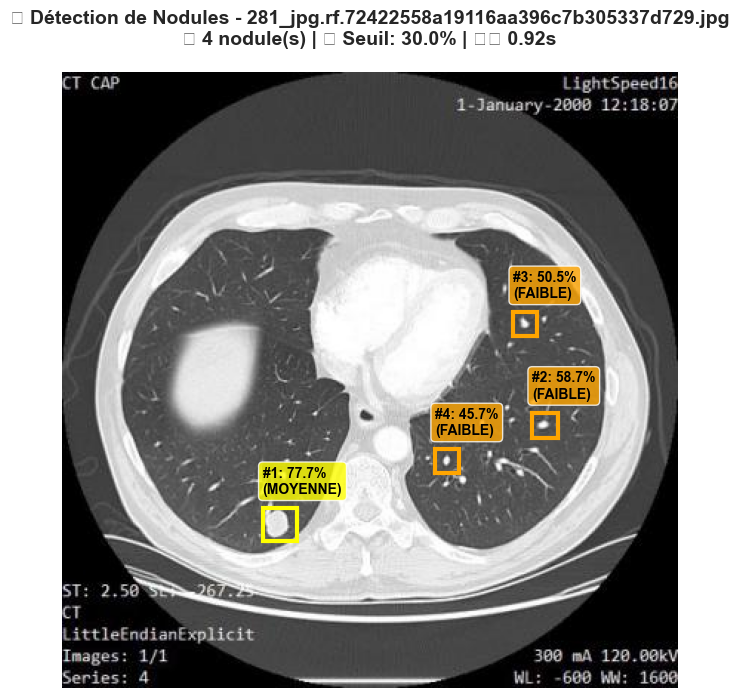

💾 Résultats sauvegardés: ../results/281_jpg.rf.72422558a19116aa396c7b305337d729_20250606_152359_results.json

✅ INFÉRENCE RÉUSSIE!


In [6]:
# ==========================================
# CELLULE 5 - TEST SUR UNE SEULE IMAGE
# ==========================================

print("\n🧪 TEST D'INFÉRENCE SUR UNE IMAGE")
print("=" * 40)

# CORRECTION: Utiliser le bon chemin (identique aux autres notebooks)
test_images_dir = Path("../data/raw/ct_images/images/val")

# Vérifier que le dossier existe
if not test_images_dir.exists():
    print(f"❌ Dossier non trouvé: {test_images_dir}")
    print("🔍 Recherche automatique des images...")

    # Rechercher dans différents emplacements possibles
    possible_paths = [
        Path("../data/raw/ct_images/images/val"),
        Path("../data/ct_images/images/val"),
        Path("../data/raw/ct_images/images/train"),  # Fallback sur train
        Path("../data/ct_images/images/train")
    ]

    test_images_dir = None
    for path in possible_paths:
        if path.exists() and list(path.glob("*.jpg")):
            test_images_dir = path
            print(f"✅ Images trouvées dans: {path}")
            break

    if test_images_dir is None:
        print("❌ AUCUNE IMAGE TROUVÉE!")
        print("💡 Solutions:")
        print("   1. Vérifier que tu as bien exécuté le notebook 02 (data processing)")
        print("   2. Vérifier la structure des dossiers:")
        print("      ../data/raw/ct_images/images/val/")
        print("      ../data/raw/ct_images/images/train/")
        raise FileNotFoundError("Aucune image de test trouvée")

# Chercher les images
image_files = list(test_images_dir.glob("*.jpg"))
if not image_files:
    print(f"❌ Aucun fichier .jpg trouvé dans {test_images_dir}")
    # Essayer .png
    image_files = list(test_images_dir.glob("*.png"))
    if not image_files:
        raise FileNotFoundError(f"Aucune image trouvée dans {test_images_dir}")

test_image_path = image_files[0]  # Première image trouvée
print(f"🖼️  Image de test: {test_image_path.name}")
print(f"📁 Dossier: {test_images_dir}")
print(f"📊 Images disponibles: {len(image_files)}")

# Exécuter l'inférence
try:
    results, original_image = inference_engine.detect_nodules(
        test_image_path,
        confidence_threshold=0.3  # Seuil bas pour voir plus de détections
    )

    # Afficher les résultats
    print(f"\n📊 RÉSULTATS:")
    print(f"   🎯 Nodules détectés: {results['total_detections']}")
    print(f"   ⏱️ Temps de traitement: {results['processing_time_seconds']:.3f}s")
    print(f"   📏 Taille originale: {results['original_image_size']}")

    if results['total_detections'] > 0:
        confidences = [d['confidence'] for d in results['detections']]
        print(f"   🔥 Confidence max: {max(confidences):.1%}")
        print(f"   📊 Confidence min: {min(confidences):.1%}")
        print(f"   📈 Confidence moyenne: {np.mean(confidences):.1%}")

        # Détail de chaque détection
        print(f"\n📋 DÉTAIL DES DÉTECTIONS:")
        for detection in results['detections']:
            det_id = detection['detection_id']
            conf = detection['confidence']
            area = detection['area_pixels']
            print(f"   Nodule #{det_id}: {conf:.1%} confidence, {area:.0f} pixels²")

    # Visualiser
    inference_engine.visualize_detections(original_image, results)

    # Sauvegarder (optionnel)
    save_path = inference_engine.save_results(results)

    print(f"\n✅ INFÉRENCE RÉUSSIE!")

except Exception as e:
    print(f"❌ Erreur lors de l'inférence: {e}")
    print("💡 Vérifications:")
    print("   - Le modèle est-il bien chargé?")
    print("   - L'image existe-t-elle?")
    print("   - Le format de l'image est-il supporté?")
    import traceback
    traceback.print_exc()

In [7]:

# ==========================================
# CELLULE 6 - TRAITEMENT PAR BATCH
# ==========================================

def process_image_batch(inference_engine, image_dir, confidence_threshold=0.5, max_images=None):
    """
    Traiter plusieurs images d'un dossier

    Args:
        inference_engine: Instance LungNoduleInference
        image_dir: Dossier contenant les images
        confidence_threshold: Seuil de confiance
        max_images: Nombre max d'images à traiter (None = toutes)

    Returns:
        list: Liste des résultats pour chaque image
    """
    image_dir = Path(image_dir)
    image_files = list(image_dir.glob("*.jpg")) + list(image_dir.glob("*.png"))

    if max_images:
        image_files = image_files[:max_images]

    print(f"🔄 TRAITEMENT PAR BATCH")
    print(f"📁 Dossier: {image_dir}")
    print(f"🖼️  Images trouvées: {len(image_files)}")
    print("-" * 40)

    all_results = []
    total_nodules = 0

    for i, image_path in enumerate(image_files, 1):
        print(f"🔄 [{i}/{len(image_files)}] {image_path.name}")

        try:
            results, _ = inference_engine.detect_nodules(image_path, confidence_threshold)
            all_results.append(results)
            total_nodules += results['total_detections']

            print(f"   ✅ {results['total_detections']} nodules | {results['processing_time_seconds']:.2f}s")

        except Exception as e:
            print(f"   ❌ Erreur: {e}")
            continue

    # Résumé
    print("-" * 40)
    print(f"📊 RÉSUMÉ BATCH:")
    print(f"   ✅ Images traitées: {len(all_results)}")
    print(f"   🎯 Total nodules: {total_nodules}")
    print(f"   📈 Moyenne: {total_nodules/len(all_results):.1f} nodules/image")

    return all_results

print("\n🚀 FONCTION DE TRAITEMENT PAR BATCH DÉFINIE")
print("💡 Usage: process_image_batch(inference_engine, '../data/test_images/', confidence_threshold=0.4, max_images=5)")


🚀 FONCTION DE TRAITEMENT PAR BATCH DÉFINIE
💡 Usage: process_image_batch(inference_engine, '../data/test_images/', confidence_threshold=0.4, max_images=5)


In [8]:
# ==========================================
# CELLULE 7 - EXPORT ET UTILITÉS
# ==========================================

def export_results_to_csv(all_results, csv_path=None):
    """
    Exporter les résultats vers un fichier CSV
    """
    import pandas as pd

    if csv_path is None:
        csv_path = RESULTS_PATH / f"inference_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"

    # Préparer les données
    data = []
    for result in all_results:
        base_info = {
            'image_name': result['image_name'],
            'timestamp': result['timestamp'],
            'processing_time_seconds': result['processing_time_seconds'],
            'total_detections': result['total_detections'],
            'confidence_threshold': result['confidence_threshold']
        }

        if result['total_detections'] == 0:
            # Pas de détections
            data.append({**base_info, 'detection_id': None, 'confidence': None, 'bbox_area': None})
        else:
            # Une ligne par détection
            for detection in result['detections']:
                data.append({
                    **base_info,
                    'detection_id': detection['detection_id'],
                    'confidence': detection['confidence'],
                    'bbox_area': detection['area_pixels'],
                    'center_x': detection['center'][0],
                    'center_y': detection['center'][1]
                })

    # Créer le DataFrame et sauvegarder
    df = pd.DataFrame(data)
    df.to_csv(csv_path, index=False)

    print(f"📊 Résultats exportés vers CSV: {csv_path}")
    print(f"   📋 {len(df)} lignes | {len(all_results)} images")

    return csv_path

def create_inference_summary(inference_engine):
    """
    Créer un résumé des inférences effectuées
    """
    stats = inference_engine.inference_stats

    summary = {
        'summary_timestamp': datetime.now().isoformat(),
        'total_images_processed': stats['total_images_processed'],
        'total_nodules_detected': stats['total_nodules_detected'],
        'average_nodules_per_image': stats['total_nodules_detected'] / max(stats['total_images_processed'], 1),
        'average_processing_time_seconds': np.mean(stats['processing_times']) if stats['processing_times'] else 0,
        'processing_speed_images_per_second': 1 / np.mean(stats['processing_times']) if stats['processing_times'] else 0,
        'model_config': CONFIG,
        'inference_history': stats['inference_history']
    }

    # Sauvegarder le résumé
    summary_path = RESULTS_PATH / f"inference_summary_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2, default=str)

    print(f"📋 Résumé d'inférence sauvegardé: {summary_path}")
    return summary

print("✅ Fonctions d'export définies")
print("\n🎉 NOTEBOOK 04 - INFÉRENCE TERMINÉ!")
print("=" * 40)
print("🚀 Ton modèle est maintenant utilisable pour:")
print("   📷 Inférence sur image unique")
print("   🔄 Traitement par batch")
print("   💾 Export des résultats (JSON, CSV)")
print("   📊 Statistiques de performance")
print("\n💡 PROCHAINE ÉTAPE: Notebook 05 - Validation avancée")

✅ Fonctions d'export définies

🎉 NOTEBOOK 04 - INFÉRENCE TERMINÉ!
🚀 Ton modèle est maintenant utilisable pour:
   📷 Inférence sur image unique
   🔄 Traitement par batch
   💾 Export des résultats (JSON, CSV)
   📊 Statistiques de performance

💡 PROCHAINE ÉTAPE: Notebook 05 - Validation avancée
